# Python API to www.argovis.com

This post is the first part of a three-part series on argovis. Supplementary tutorial videos are found [here](https://www.youtube.com/watch?v=UOjSV4EIy00&list=PLJQE6R74BkyVV3PeTRdGh-W5llAY4XJ8v).
1. [Argovis api](http://www.itsonlyamodel.us/argovis-python-api.html) introduces my website [www.argovis.com](http://www.argovis.com), and how users can access data using a python API. 
2. [Linear time series analysis in R](http://www.argo.ucsd.edu/r-time-series-fit.html) shows how time series models can be used to fit ocean temperatures from Argo data.
3. [Linear time series model fitting in python](http://www.argo.ucsd.edu/python-time-series-fit.html) gives further detail on how non-linear least squares fitting is typically done on time series. 

For over a decade, the [ARGO](http://www.argo.ucsd.edu/index.html) program has provided temperature, salinity and pressure data (T/S/P) on a global scale for depths as far as 6000 meters, with unprecedented spatial and temporal resolution and no seasonal bias. Close to two million profiles have been collected and made publicly available on Argo’s Global Data Assembly Centres (GDACs) on FTP servers. Unfortunately, online tools for selection and visualization of this big data set are limited slow to access.

In response, a web app [www.argovis.com](http://www.argovis.com) attempts to improve visualization and data retreval of the Argo dataset. Argo now has a maintainable, scalable, and portable tool written with representational state transfer (REST) architecture. RESTful design offers us the opportunity to feature cloud computing applications; chiefly, map comparison from existing gridded Argo products, as well as parameter estimation such as basin mean T/S/P.

The following code is a way to get ocean data stored on Argovis. HTTP 'get' requests access the web app's database; however, without a browser. Essentially, this interface is used to query the same database that builds the website.

This blogpost will guide a python user to:

[1. Query a specific profile its id, designated by its platform (WMO) number with its cycle number, connected by an underscore. For example '3900737_9'](#section_one)

[2. Query a specified platform by number. Example '3900737'.](#section_two)

[3.1 Query profiles within a given shape, date range, and pressure range.](#section_three)

[3.2 Query profiles position, date, and cycle number within month and year.](#section_three_two)

[4. Plot query results](#section_four)

[5. Create time series given for a selection and set of dates.](#section_five)

[6. Query database using a gridded scheme](#section_six)

[7. Plot gridded data using Cartopy](#section_seven)

Firstly, following libraries are called

In [1]:
import requests
import numpy as np
import pandas as pd

import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from datetime import datetime
import pdb
import os

#used for map projections
from cartopy import config
import cartopy.crs as ccrs

%matplotlib inline

#sets plot styles
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=False)
rcStyle = {"font.size": 10,
           "axes.titlesize": 20,
           "axes.labelsize": 20,
           'xtick.labelsize': 16,
           'ytick.labelsize': 16}
sns.set_context("paper", rc=rcStyle)
sns.set_style("whitegrid", {'axes.grid' : False})
myColors = ["windows blue", "amber", "dusty rose", "prussian blue", "faded green", "dusty purple", "gold", "dark pink", "green", "red", "brown"]
colorsBW = ["black", "grey"]
sns.set_palette(sns.xkcd_palette(myColors))

curDir = os.getcwd()
docDir = os.path.join(curDir, 'docs', 'argo')

<a name="section_one"/> </a>
# 1. Get A Profile

The requests library handles the HTTP getting and receiving. If the message is received and the profile exists Argovis will return a JSON object. Python casts a JSON object as a native dictionary type. 

in this example we are going to access the profile from float 3900737 cycle 279. The function below builds the following url, requests json data, and returns it in python.

[https://argovis.colorado.edu/catalog/profiles/3900737_279](https://argovis.colorado.edu/catalog/profiles/3900737_279)

In [2]:
def get_profile(profile_number):
    url = 'https://argovis.colorado.edu/catalog/profiles/{}'.format(profile_number)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

The pandas dataframe object is better suited to handle manipulations. Essentially it is a spreadsheet table.

In [3]:
profileDict = get_profile('3900737_279')
profileDf = pd.DataFrame(profileDict['measurements'])
profileDf['cycle_number'] = profileDict['cycle_number']
profileDf['profile_id'] = profileDict['_id']
profileDf.head()

,pres,psal,temp,cycle_number,profile_id
0,4.4,35.421,27.165,279,3900737_279
1,10.0,35.421,27.063,279,3900737_279
2,16.9,35.422,27.055,279,3900737_279
3,23.7,35.422,27.048,279,3900737_279
4,30.9,35.421,27.046,279,3900737_279


With the data in this form, we can plot it with our favorite library, matplotlib. Try different styles.

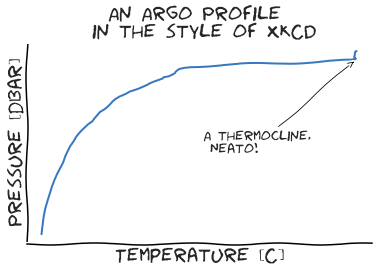

In [4]:
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    dataX = profileDf.pres.values
    dataY = profileDf.temp.values
    ax.plot(dataY, dataX)

    ax.set_title('An Argo Profile \n in the style of XKCD')
    ax.set_xlabel('Temperature [C]')
    ax.set_ylabel('Pressure [dbar]')
    
    ax.annotate(
    'A thermocline, \n Neato!',
    xy=(dataY[12], dataX[12]+10), arrowprops=dict( color='k', arrowstyle='->'), xytext=(15, 1100))

<a name="section_two"/> </a>
# 2. Get A Platform

A platform consists of a list of profiles. An additional function 'parse_into_df' appends each profile to one data frame.

In this example we are constructing the url:
[https://argovis.colorado.edu/catalog/platforms/3900737](https://argovis.colorado.edu/catalog/platforms/3900737)

In [5]:
def get_platform_profiles(platform_number):
    url = 'https://argovis.colorado.edu/catalog/platforms/{}'.format(platform_number)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    platformProfiles = resp.json()
    return platformProfiles

def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

In [6]:
platformProfiles = get_platform_profiles('3900737')
platformDf = parse_into_df(platformProfiles)
print('number of measurements {}'.format(platformDf.shape[0]))

number of measurements 25609


In [7]:
platformDf.head()

,temp,psal,pres,cycle_number,profile_id,lat,lon,date
0,26.349,33.770,4.4,1.0,3900737_1,0.931,-84.083,2009-06-15T11:13:53.000Z
1,26.356,33.781,10.5,1.0,3900737_1,0.931,-84.083,2009-06-15T11:13:53.000Z
2,26.294,33.894,17.7,1.0,3900737_1,0.931,-84.083,2009-06-15T11:13:53.000Z
3,26.014,34.198,24.6,1.0,3900737_1,0.931,-84.083,2009-06-15T11:13:53.000Z
4,24.573,34.716,31.6,1.0,3900737_1,0.931,-84.083,2009-06-15T11:13:53.000Z


By the way, Pandas dataframes can handle large arrays efficiently, thanks to the underlying numpy library. Pandas allows for easy and quick computations, such as taking the mean of the measurements.

In [8]:
platformDf[['pres', 'psal', 'temp']].mean(0)

pres    539.346652
psal     34.905583
temp     12.602862
dtype: float64

<a name="section_three"/> </a>
# 3.1 Get A Space-Time Selection

This query retrieves profiles within a given shape, date range, and optional depth range.

[This region's](https://argovis.colorado.edu/selection/profiles/page?startDate=2017-9-15&endDate=2017-10-31&shape=[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]&presRange=[0,30]) data will be queried and plotted in Python.

* start date: string formatted as 'YYYY-MM-DD'
* end date: string formatted as 'YYYY-MM-DD'
* pressure range (optional): string formatted as '[lowerPressure,upperPressure]'. No Spaces!
* polygon: a list of lists containing [lng,lat] coordinates. See code below


In [9]:
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    url = 'https://argovis.colorado.edu/selection/profiles'
    url += '?startDate={}'.format(startDate)
    url += '&endDate={}'.format(endDate)
    url += '&shape={}'.format(shape)
    if presRange:
        pressRangeQuery = '&presRange=' + presRange
        url += pressRangeQuery
    print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

In [10]:
startDate='2017-9-15'
endDate='2017-10-31'
shape = '[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]'
presRange='[0,30]'

selectionProfiles = get_selection_profiles(startDate, endDate, shape, presRange)
if len(selectionProfiles) > 0:
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)

https://argovis.colorado.edu/selection/profiles?startDate=2017-9-15&endDate=2017-10-31&shape=[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]&presRange=[0,30]


In [11]:
selectionDf.columns

Index(['temp', 'psal', 'pres', 'cycle_number', 'profile_id', 'lat', 'lon',
       'date'],
      dtype='object')

There are 30 profiles in this selection.

In [12]:
len(selectionDf['profile_id'].unique())

29

Let's make a contour plots of our selection.

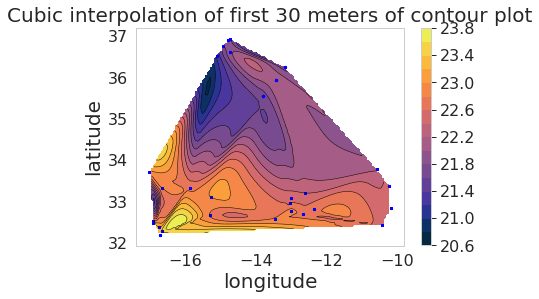

In [13]:
def contourPlot(df):
    fig = plt.figure()
    axes = plt.axes()
    xi = np.linspace(df['lon'].min(),df['lon'].max(),100)
    yi = np.linspace(df['lat'].min(),df['lat'].max(),100)
    
    x = df['lon'].values
    y = df['lat'].values
    z = df['temp'].values
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    CS = plt.contourf(xi,yi,zi,15,cmap=cmocean.cm.thermal)
    axes.scatter(x,y,marker='o',c='b',s=5)
    axes.set_title('Cubic interpolation of first 30 meters of contour plot')

    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    cbar = fig.colorbar(CS, cmap = cmocean.cm.thermal)
    return fig

fig1 = contourPlot(selectionDf)

<a name="section_three_two"/> </a>
## 3.2 Metadata selection for month and year

For profile metadata, data can be accessed quickly with the following API. This will be useful in [section 7](#section_seven)

In [14]:
def get_monthly_profile_pos(month, year):
    url = 'https://argovis.colorado.edu/selection/profiles'
    url += '/{0}/{1}'.format(month, year)
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    monthlyProfilePos = resp.json()
    return monthlyProfilePos

month = 1 # January
year = 2019 # Year 2019
monthlyProfilePos = get_monthly_profile_pos(month, year)
monthlyDf = pd.DataFrame(monthlyProfilePos)
monthlyDf.head()

,BASIN,DATA_MODE,PI_NAME,PLATFORM_TYPE,POSITIONING_SYSTEM,VERTICAL_SAMPLING_SCHEME,_id,containsBGC,cycle_number,dac,...,isDeep,lat,lon,platform_number,position_qc,pres_max_for_PSAL,pres_max_for_TEMP,pres_min_for_PSAL,pres_min_for_TEMP,station_parameters
0,10,D,Steve Rintoul,APEX,GPS,Primary sampling: averaged [],5904229_226,False,226,csiro,...,False,-64.13300,-108.81600,5904229,1,1994.38,1994.38,2.78,2.78,"[psal, temp, pres]"
1,3,A,ZENGHONG LIU,PROVOR,ARGOS,Primary sampling: averaged [],2902585_166,False,166,csio,...,False,43.36300,139.44400,2902585,1,1961.00,1961.00,1.00,1.00,"[psal, temp, pres]"
2,2,D,DEAN ROEMMICH,SOLO_D,GPS,Primary sampling: mixed [PRES <= 504 dbar: no...,5905234_39D,False,39,aoml,...,False,-44.05055,-148.28209,5905234,1,5447.00,5447.00,1.00,1.00,"[pres, pres_qc, psal, psal_qc, temp, temp_qc]"
3,2,D,DEAN ROEMMICH,SOLO_II,GPS,Primary sampling: averaged [nominal 2 dbar b...,5902387_140,False,140,aoml,...,False,-43.89198,153.50472,5902387,1,2003.32,2003.32,1.12,1.12,"[pres, psal, temp]"
4,3,A,Susan Wijffels,APEX,GPS,Primary sampling: averaged [],5904899_157,False,157,csiro,...,False,-44.96800,106.87900,5904899,1,1989.72,1989.72,2.62,2.62,"[psal, temp, pres]"


### Gathering all of the metadata

We can loop over months, saving the results as csv files.

In [85]:
def make_grouped_meta_data(docDir):
    dateRange = pd.date_range('2004-01-01', '2019-01-01', periods=None, freq='M')

    profTimeSeries = []
    typeTimeSeries = []
    psTimeSeries = []
    dacTimeSeries = []

    for date in dateRange:
        month = date.to_pydatetime().month
        year = date.to_pydatetime().year
        monthlyProfilePos = get_monthly_profile_pos(month, year)
        monthlyDf = pd.DataFrame(monthlyProfilePos)
        monthDict = {'date': date, 'nProf': len(monthlyProfilePos)}

        allDict = {}
        allDict.update(monthDict)

        platformType = monthlyDf.groupby('PLATFORM_TYPE')['_id'].count().to_dict()
        platformType.update(monthDict)
        typeTimeSeries.append(platformType)
        allDict.update(platformType)

        ps = monthlyDf.groupby('POSITIONING_SYSTEM')['_id'].count().to_dict()
        ps.update(monthDict)
        psTimeSeries.append(ps)
        allDict.update(ps)

        dac = monthlyDf.groupby('dac')['_id'].count().to_dict()
        dac.update(monthDict)
        dacTimeSeries.append(dac)
        allDict.update(dac)

        profTimeSeries.append(allDict)
    save_metadata_time_series(docDir, 'groupedProfileTimeSeries.csv', profTimeSeries)
    save_metadata_time_series(docDir, 'groupedProfilePositioningSystemTimeSeries.csv', psTimeSeries)
    save_metadata_time_series(docDir, 'groupedProfileTypeTimeSeries.csv', typeTimeSeries)
    save_metadata_time_series(docDir, 'groupedDacTimeSeries.csv', dacTimeSeries) 

def save_metadata_time_series(docDir, filename, metadataDict):
    filename = os.path.join(docDir, filename)
    df = pd.DataFrame(metadataDict)
    df.to_csv(filename, index=False)
    
def get_grouped_metadata(docDir, filename):
    df = pd.read_csv(os.path.join(docDir,filename))
    df['date'] = pd.to_datetime(df['date'])
    return df

In [86]:
make_grouped_meta_data(docDir)

In [87]:
profTimeSeriesDf = get_grouped_metadata(docDir, 'groupedProfileTimeSeries.csv')
psTimeSeriesDf = get_grouped_metadata(docDir, 'groupedProfilePositioningSystemTimeSeries.csv')
typeTimeSeriesDf = get_grouped_metadata(docDir, 'groupedProfileTypeTimeSeries.csv')
dacTimeSeriesDf = get_grouped_metadata(docDir, 'groupedDacTimeSeries.csv')

In [88]:
dacTimeSeriesDf.head()

,aoml,bodc,coriolis,csio,csiro,date,incois,jma,kma,kordi,meds,nProf,nmdis
0,1057,98,401,19,59,2004-01-31,81,434,36,49,210,2444,NaN
1,1033,89,374,20,55,2004-02-29,75,433,33,48,191,2351,NaN
2,1199,91,424,20,59,2004-03-31,80,456,39,49,197,2614,NaN
3,1255,90,394,20,57,2004-04-30,67,422,33,46,185,2569,NaN
4,1408,100,400,17,55,2004-05-31,105,410,36,51,199,2781,NaN


<a name="section_four"/> </a>
# 4. Plotting metadata results

Argovis's plotting capabilities are limited to what is coded in JavaScript. There are many plotting libraries out there, but in this example we can create plots on our machine, thereby allowing customization.

We just made some dataframes containing profile meta data. We can plot these time series with the following function.

In [89]:
def make_stack_plot(df, figsize=(6,3)):
    dataDf = df.drop(['date', 'nProf'], axis=1)
    fig = plt.figure(figsize=figsize)
    axes = plt.axes()
    axes.set_title('Number of profiles per month vs. time')
    axes.set_ylabel('# profiles/month')
    axes.set_xlabel('Date')
    axes.stackplot(df['date'].values, dataDf.T, labels=dataDf.columns)
    axes.legend(loc=2, fontsize=16)
    return fig

/home/tyler/anaconda3/envs/AR/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


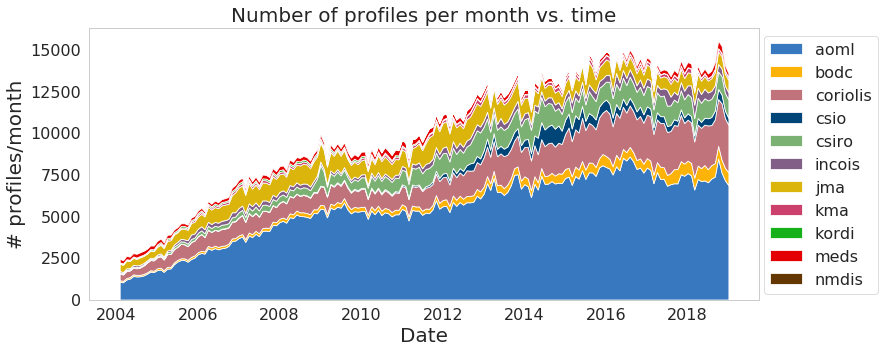

In [191]:
fig = make_stack_plot(dacTimeSeriesDf, figsize=(12,5))
axes = plt.axes()
axes.legend(bbox_to_anchor=(1.19, 1.00), fontsize=16)

Here we can see which dacs are producing results over time. The next plot shows which transmission system the profiles are using. I lumped Iridium and GPS into one field. They are essentially equivalent.

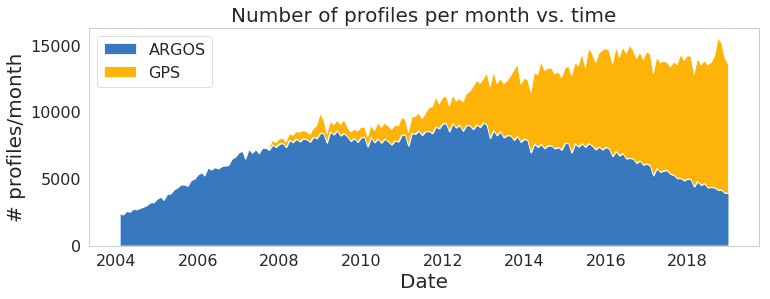

In [188]:
psdf=psTimeSeriesDf.copy()
psdf['GPS'] = psTimeSeriesDf['GPS'] + psTimeSeriesDf['IRIDIUM']
psdf.drop('GTS', axis = 1, inplace=True)
psdf.drop('IRIDIUM', axis = 1, inplace=True)
fig = make_stack_plot(psdf, figsize=(12,4))

<a name="section_five"/> </a>
# 5. Time series

Stacking selection queries on top of each other, we can build a time series. 

Suppose that we average the temperature of our selection, and we give this value a time index. Repeating this process with an array of date ranges, we can create a time series. Just a disclaimer, this selection should be spatially averaged, but is left out; this is only a demonstration. 

In [95]:
def get_platform_measurements(profiles):
    '''
    Retrieves all measurements included in a list of platforms.
    '''
    stationParam = []
    for profile in profiles:
        stationParam.append(profile['station_parameters'])
    flatList = [item for sublist in stationParam for item in sublist]
    if isinstance(flatList[0], list):
        flatList = [item for sublist in flatList for item in sublist]
    uniqueList = list(set(flatList))
    uniqueList = [s for s in uniqueList if s != ''] # ignore blank station params.
                
    measurement_keys = [x.lower() for x in uniqueList]   
    return measurement_keys

def get_dates_set(period=30):
    n_rows = int(np.floor(365/period))
    datesSet = []
    for year in range(2004, 2018):
        yearSet = np.array_split(pd.date_range(str(year)+'-01-01', str(year)+'-12-31'), n_rows)
        datesSet = datesSet + yearSet
    keepEnds = lambda x: [x[0].strftime(format='%Y-%m-%d'), x[-1].strftime(format='%Y-%m-%d')]
    datesSet = list(map(keepEnds, datesSet))
    return datesSet

def get_ocean_time_series(seriesStartDate, seriesEndDate, shape, presRange='[0, 30]'):
    """Queries argovis database over long time scales but over one shape.
    shape should have a radius of no more than a few degrees.
    Pressure range should about 10-50 dbar.
    """
    
    selectionProfiles = get_selection_profiles(seriesStartDate, seriesEndDate, shape, presRange)
    if len(selectionProfiles) == 0:
        return
    meas_keys = get_platform_measurements(selectionProfiles)
    meas_keys = [s for s in meas_keys if s != ''] # ignore profiles that dont report anything
    print('Selection measurements: {}'.format(meas_keys))
    df = parse_into_df(selectionProfiles)
    
    #provide a time index for date ranges
    datesSet = get_dates_set(31)
    dateFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
    df['date'] =  pd.to_datetime(df['date'], format=dateFormat)
    for idx, dates in enumerate(datesSet):
        startDate = datetime.strptime(dates[0], '%Y-%m-%d')
        endDate = datetime.strptime(dates[1], '%Y-%m-%d')
        try:
            if df[ (df['date'] < endDate) & (df['date'] > startDate)].shape[0] > 0: # sometimes there aren't any profiles at certain depth intervals
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'tIndex'] = idx
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'startDate'] = startDate
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'endDate'] = endDate
        except ValueError:
            pdb.set_trace()
            df[ (df['date'] < startDate) & (df['date'] > endDate)].shape[0]

    df = df[np.isfinite(df['tIndex'])]
    #df.dropna(axis=1, how='any', inplace=True)
    #group and aggregate over tIndex
    tsDf = pd.DataFrame()
    grouped = df.groupby('tIndex')

    for tdx, group in grouped:
        nMeas = group.shape[0]
        if nMeas == 0:
            continue
        try:
            aggMean = group[meas_keys][group[meas_keys] != -999].mean()
            aggStd = group[meas_keys][group[meas_keys] != -999].std()
        except KeyError:
            pdb.set_trace()
            grouped.columns
        startDate = group['startDate'].values[0]
        endDate = group['endDate'].values[0]
        for key in meas_keys:
            tsDf.at[tdx, key+'Mean'] = aggMean[key]
            tsDf.at[tdx, key+'Std'] = aggStd[key]
        tsDf.at[tdx, 'startDate'] = startDate
        tsDf.at[tdx, 'endDate'] = endDate
        tsDf.at[tdx, 'nProf'] = nMeas
    return tsDf

In [96]:
tsDf = get_ocean_time_series('2004-01-01', '2017-12-31', shape, presRange='[0, 30]')
tsDf.to_csv(os.path.join(docDir,'gilbralter.csv'))

https://argovis.colorado.edu/selection/profiles?startDate=2004-01-01&endDate=2017-12-31&shape=[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]&presRange=[0, 30]
Selection measurements: ['cndc', 'pres', 'temp', 'psal']


Text(0.5, 0, '$Year$')

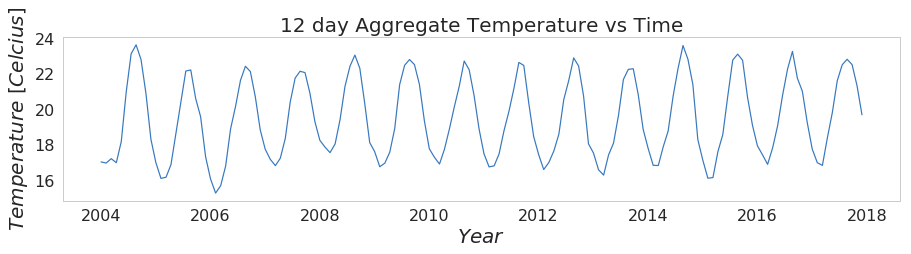

In [97]:
tsDf = pd.read_csv(os.path.join(docDir,'gilbralter.csv'))
tsDf['startDate'] = pd.to_datetime(tsDf['startDate'])
tsDf['endDate'] = pd.to_datetime(tsDf['endDate'])
fig = plt.figure(999, figsize=(15,3))
axes = plt.axes()
temp = tsDf['tempMean'].values
time = tsDf['startDate'].values
axes.plot(time, temp)
axes.set_title(r'12 day Aggregate Temperature vs Time')
axes.set_ylabel(r'$Temperature\ [Celcius]$')
axes.set_xlabel(r'$Year$')

<a name="section_six"/> </a>
# 6. Query by slice 

Where the get_ocean_time_series function goes through long time ranges, the get_ocean_df_from_csv queries a thin vertical slice of ocean over a short period of time.

In [15]:
def get_ocean_slice(startDate, endDate, presRange='[5,15]'):
    '''
    query horizontal slice of ocean for a specified time range
    startDate and endDate should be a string formated like so: 'YYYY-MM-DD'
    presRange should comprise of a string formatted to be: '[lowPres,highPres]'
    Try to make the query small enough so as to not pass the 15 MB limit set by the database.
    '''
    baseURL = 'https://argovis.colorado.edu/gridding/presSlice/'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    presRangeQuery = '&presRange=' + presRange
    url = baseURL + startDateQuery + endDateQuery + presRangeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profiles = resp.json()
    return profiles

In [16]:
presRange = '[50, 55]' #  used to query database
startDate='2017-10-15'
endDate='2017-10-30'
sliceProfiles = get_ocean_slice(startDate, endDate, presRange)
sliceDf = parse_into_df(sliceProfiles)

### Gridding

We can bin the lat-lon values into a grid of our choosing. Here we bin our dataframe into a 10 by 10 degree lat-lon grid. We also tally the number of profiles in each grid cell.

In [17]:
def to_bin(x, delta):
    if x % (delta) <= delta/2:
        return np.floor(x / delta) * delta
    else:
        return np.ceil(x / delta) * delta

def bin_layer_df(df, deltaLat, deltaLon):
    df['latbin'] = df.lat.apply(lambda lat: to_bin(lat, deltaLat))
    df['lonbin'] = df.lon.apply(lambda lon: to_bin(lon, deltaLon))
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['profile_id'].groupby(level=['latbin', 'lonbin']).count()
    df = df.reset_index()
    return df

In [18]:
sliceDf = bin_layer_df(sliceDf, 10, 10)

In [19]:
sliceDf.head()

,latbin,lonbin,temp,psal,pres,cycle_number,profile_id,lat,lon,date,pres_qc,psal_qc,temp_qc,nProf
0,40.0,20.0,15.476,38.927,51.3,337.0,6901822_337,41.352707,18.246482,2017-10-29T23:58:59.999Z,NaN,NaN,NaN,147
1,40.0,20.0,15.438,38.927,53.4,337.0,6901822_337,41.352707,18.246482,2017-10-29T23:58:59.999Z,NaN,NaN,NaN,147
2,40.0,10.0,21.372,37.906,51.0,283.0,6901816_283,40.640778,5.175762,2017-10-29T23:58:00.000Z,NaN,NaN,NaN,101
3,40.0,10.0,21.295,37.91,53.7,283.0,6901816_283,40.640778,5.175762,2017-10-29T23:58:00.000Z,NaN,NaN,NaN,101
4,40.0,10.0,21.142,38.339,51.5,229.0,6901823_229,38.952302,9.511905,2017-10-29T23:58:00.000Z,NaN,NaN,NaN,101


<a name="section_seven"/> </a>
# 7. Plot on map projections

There are a few options in python when plotting on map projections. Let’s use the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

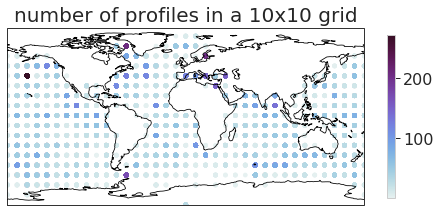

In [20]:
def plot_pmesh(df):
    fig = plt.figure(figsize=(8,12))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    granularity = 50j
    df.sort_values(by=['lonbin', 'latbin'], ascending=[True, False], inplace=True)
    x = df['lonbin'].values
    y = df['latbin'].values
    z = df['nProf'].values
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title('number of profiles in a 10x10 grid')

    ax.coastlines(zorder=1)
    sct = plt.scatter(x, y, c=z,s=15, cmap=cmocean.cm.dense,zorder=0)
    cbar = fig.colorbar(sct, cmap=cmocean.cm.dense, shrink=.25)
    return fig

pmeshfig = plot_pmesh(sliceDf)
plt.show()

# Conclusion

The three main functions described in sections 1, 2, and 3 can be written in a number or languages, such as R or Matlab. This project is still new, and will continue to evolve and improve. Feel free to email tyler.tucker@colorado.edu for questions/requests. Thanks!